#Setup

In [2]:
!pip install praw openai transformers numpy requests nlpaug nltk>=3.4.5

In [3]:
import praw
import pandas as pd

# Create Dataset

In [ ]:
# Read-only instance
reddit_read_only = praw.Reddit(client_id="", # your client id
                               client_secret="", # your client secret
                               user_agent="") # your user agent

In [ ]:
subreddit = reddit_read_only.subreddit("offmychest")

for post in subreddit.hot(limit=5):
    print(post.title)
    print()

It is strongly recommended to use Async PRAW: https://asyncpraw.readthedocs.io.
See https://praw.readthedocs.io/en/latest/getting_started/multiple_instances.html#discord-bots-and-asynchronous-environments for more info.



We have persistent scammers preying on this community

Stop accusing posts of being AI.

Im having sex with my landlord..

i texted a dead woman for a year and no one knows

I regret having kids



In [ ]:
posts = subreddit.top(limit=1000)
# Scraping the top posts of the current month

posts_dict = {"Title": [], "Post Text": [],
              "ID": [], "Score": [],
              "Total Comments": [], "Post URL": []
              }

for post in posts:
    posts_dict["Title"].append(post.title)
    posts_dict["Post Text"].append(post.selftext)
    posts_dict["ID"].append(post.id)
    posts_dict["Score"].append(post.score)
    posts_dict["Total Comments"].append(post.num_comments)
    posts_dict["Post URL"].append(post.url)

top_posts = pd.DataFrame(posts_dict)
top_posts

It is strongly recommended to use Async PRAW: https://asyncpraw.readthedocs.io.
See https://praw.readthedocs.io/en/latest/getting_started/multiple_instances.html#discord-bots-and-asynchronous-environments for more info.

It is strongly recommended to use Async PRAW: https://asyncpraw.readthedocs.io.
See https://praw.readthedocs.io/en/latest/getting_started/multiple_instances.html#discord-bots-and-asynchronous-environments for more info.

It is strongly recommended to use Async PRAW: https://asyncpraw.readthedocs.io.
See https://praw.readthedocs.io/en/latest/getting_started/multiple_instances.html#discord-bots-and-asynchronous-environments for more info.

It is strongly recommended to use Async PRAW: https://asyncpraw.readthedocs.io.
See https://praw.readthedocs.io/en/latest/getting_started/multiple_instances.html#discord-bots-and-asynchronous-environments for more info.

It is strongly recommended to use Async PRAW: https://asyncpraw.readthedocs.io.
See https://praw.readthedocs.io/en/l

,Title,Post Text,ID,Score,Total Comments,Post URL
0,Today I saw the man that saved me when I was b...,When I was 13 years old I was raped behind a c...,g4ewp7,36180,234,https://www.reddit.com/r/offmychest/comments/g...
1,I hate my life. I hate my kid. I resent my fam...,"I never wanted kids, but was never adamantly a...",icgf9e,35342,1095,https://www.reddit.com/r/offmychest/comments/i...
2,I’m in love with my gym bro,I (Male 22) fell in love with my gym bro (Male...,ugcb2i,31124,4199,https://www.reddit.com/r/offmychest/comments/u...
3,To those who are stockpiling over the Coronavi...,"Because of you, people are unable to buy the b...",fgj4m9,30771,1873,https://www.reddit.com/r/offmychest/comments/f...
4,I fucking hate donald trump,not much more needs to be said than that. he's...,gvurgy,26352,1980,https://www.reddit.com/r/offmychest/comments/g...
...,...,...,...,...,...,...
989,I’m a girl but I wish I had a penis,\nI wish I had a dick so I could fuck my boyfr...,1e9la3w,5016,859,https://www.reddit.com/r/offmychest/comments/1...
990,I GOT THE JOB,I AM SO HAPPY! I HAVE BEEN OUT OF WORK FOR THE...,jepe6a,5018,129,https://www.reddit.com/r/offmychest/comments/j...
991,Just Paid off over $100k in Student Debt,Title. Took my wife and I 10 years but it's ov...,ja1sm8,5016,193,https://www.reddit.com/r/offmychest/comments/j...
992,My bf just said that he would “beat the shit o...,I’m currently at my bf’s house and we were jok...,wo8w62,5011,1613,https://www.reddit.com/r/offmychest/comments/w...


In [ ]:
lengths = top_posts["Post Text"].str.len()
long_posts = top_posts[lengths >= 200]
long_posts.count()

,0
Title,917
Post Text,917
ID,917
Score,917
Total Comments,917
Post URL,917


In [ ]:
def get_posts_from_subreddit(subreddits, limit):
  posts_dict = {"id": [], "title": [], "text": [], "subreddit": []}

  for subreddit_name in subreddits:
    subreddit = reddit_read_only.subreddit(subreddit_name)
    posts = subreddit.top(limit = limit)

    for post in posts:
        posts_dict["id"].append(post.id)

        posts_dict["title"].append(post.title)

        posts_dict["text"].append(post.selftext)

        posts_dict["subreddit"].append(subreddit_name)

  return posts_dict


In [ ]:
subreddits = ["offmychest", "DecidingToBeBetter", "TrueOffMyChest", "mentalhealth", "relationships"]
limit = 1000

reddit_posts = get_posts_from_subreddit(subreddits, limit)

It is strongly recommended to use Async PRAW: https://asyncpraw.readthedocs.io.
See https://praw.readthedocs.io/en/latest/getting_started/multiple_instances.html#discord-bots-and-asynchronous-environments for more info.

It is strongly recommended to use Async PRAW: https://asyncpraw.readthedocs.io.
See https://praw.readthedocs.io/en/latest/getting_started/multiple_instances.html#discord-bots-and-asynchronous-environments for more info.

It is strongly recommended to use Async PRAW: https://asyncpraw.readthedocs.io.
See https://praw.readthedocs.io/en/latest/getting_started/multiple_instances.html#discord-bots-and-asynchronous-environments for more info.

It is strongly recommended to use Async PRAW: https://asyncpraw.readthedocs.io.
See https://praw.readthedocs.io/en/latest/getting_started/multiple_instances.html#discord-bots-and-asynchronous-environments for more info.

It is strongly recommended to use Async PRAW: https://asyncpraw.readthedocs.io.
See https://praw.readthedocs.io/en/l

In [ ]:
reddit_posts_df = pd.DataFrame(reddit_posts)
reddit_posts_df

,id,title,text,subreddit
0,g4ewp7,Today I saw the man that saved me when I was b...,When I was 13 years old I was raped behind a c...,offmychest
1,icgf9e,I hate my life. I hate my kid. I resent my fam...,"I never wanted kids, but was never adamantly a...",offmychest
2,ugcb2i,I’m in love with my gym bro,I (Male 22) fell in love with my gym bro (Male...,offmychest
3,fgj4m9,To those who are stockpiling over the Coronavi...,"Because of you, people are unable to buy the b...",offmychest
4,gvurgy,I fucking hate donald trump,not much more needs to be said than that. he's...,offmychest
...,...,...,...,...
4759,1kpiccf,My husband (63M) goes cycling way too much lea...,"Good people, I need some help.\n\nMy husband (...",relationships
4760,1eped8y,I caught my husband cheating last night,I (F 27) have been married to my husband (28) ...,relationships
4761,1lqes2m,"For some reason, I (40F) have been rejected by...",Husband and I have been together for 3 years a...,relationships
4762,1kikjre,Wife 2+ hours of alarms are pushing me to my b...,Me (F32) and my wife (F30) have very different...,relationships


In [ ]:
reddit_posts_df.to_csv("data/raw_data.csv", sep='\t', encoding='utf-8', index=False, header=True)

# Data Pre Processing

In [ ]:
reddit_posts_df = pd.read_csv("data/raw_data.csv", sep='\t')
reddit_posts_df

,id,title,text,subreddit
0,g4ewp7,Today I saw the man that saved me when I was b...,When I was 13 years old I was raped behind a c...,offmychest
1,icgf9e,I hate my life. I hate my kid. I resent my fam...,"I never wanted kids, but was never adamantly a...",offmychest
2,ugcb2i,I’m in love with my gym bro,I (Male 22) fell in love with my gym bro (Male...,offmychest
3,fgj4m9,To those who are stockpiling over the Coronavi...,"Because of you, people are unable to buy the b...",offmychest
4,gvurgy,I fucking hate donald trump,not much more needs to be said than that. he's...,offmychest
...,...,...,...,...
4759,1kpiccf,My husband (63M) goes cycling way too much lea...,"Good people, I need some help.\n\nMy husband (...",relationships
4760,1eped8y,I caught my husband cheating last night,I (F 27) have been married to my husband (28) ...,relationships
4761,1lqes2m,"For some reason, I (40F) have been rejected by...",Husband and I have been together for 3 years a...,relationships
4762,1kikjre,Wife 2+ hours of alarms are pushing me to my b...,Me (F32) and my wife (F30) have very different...,relationships


In [5]:
import re
def clean_for_baseline(text):
    text = text.lower()
    text = re.sub(r"http\S+", "", text)
    text = re.sub(r"[^a-z\s]", "", text)
    text = re.sub(r"\s+", " ", text).strip()
    return text

In [6]:
cleaned_posts_df = reddit_posts_df
cleaned_posts_df = cleaned_posts_df[cleaned_posts_df["text"].notnull()]
cleaned_posts_df = cleaned_posts_df[~cleaned_posts_df["text"].str.contains("removed|deleted", case=False)]
cleaned_posts_df = cleaned_posts_df[cleaned_posts_df["text"].str.len() >= 200]
cleaned_posts_df["full_text"] = cleaned_posts_df["title"] + " " + cleaned_posts_df["text"]

In [7]:
def heuristic_label(text):
    text = text.lower()
    if any(kw in text for kw in ["everything is ruined", "worst thing ever", "disaster"]):
        return "catastrophizing"
    elif any(kw in text for kw in ["always", "never", "everyone", "no one"]):
        return "overgeneralization"
    elif any(kw in text for kw in ["they think", "they must believe", "they want"]):
        return "mind reading"
    elif any(kw in text for kw in ["it’s my fault", "i caused", "because of me"]):
        return "personalization"
    elif any(kw in text for kw in ["i feel like", "i know it’s true because i feel it"]):
        return "emotional reasoning"
    else:
        return "none"

cleaned_posts_df['label'] = cleaned_posts_df['full_text'].apply(heuristic_label)

In [8]:
unlabeled_posts_df = cleaned_posts_df[cleaned_posts_df['label'] == "none"]
unlabeled_posts_df

,id,title,text,subreddit,full_text,label
9,hlaopw,I’m an Iraq War veteran who risked his life fo...,"I am so ashamed of our president, his bullying...",offmychest,I’m an Iraq War veteran who risked his life fo...,none
10,ce40pa,I did it.,"7 years ago, when I was 24, my wife was killed...",offmychest,"I did it. 7 years ago, when I was 24, my wife ...",none
14,gsidz2,Peaceful Protest Was Made Impossible,My hometown is burning. The target I shopped a...,offmychest,Peaceful Protest Was Made Impossible My hometo...,none
17,fx1h9u,I (23F) have nobody in this world.,I've been alone in my tiny studio apartment fo...,offmychest,I (23F) have nobody in this world. I've been a...,none
19,ixono6,My country is dead (USA),I just learned Mitt Romney endorsed confirming...,offmychest,My country is dead (USA) I just learned Mitt R...,none
...,...,...,...,...,...,...
4754,1ejtnih,My(M40) wifes(F35) career choice has turned in...,My wife and I have been married for 10 years a...,relationships,My(M40) wifes(F35) career choice has turned in...,none
4756,1dpc7ac,Husband left our son without formula,Husband (married 8 years) left our son (7 mont...,relationships,Husband left our son without formula Husband ...,none
4758,1ht8ogl,UPDATE: Boyfriend slept with someone else whil...,Origional post: https://www.reddit.com/r/relat...,relationships,UPDATE: Boyfriend slept with someone else whil...,none
4759,1kpiccf,My husband (63M) goes cycling way too much lea...,"Good people, I need some help.\n\nMy husband (...",relationships,My husband (63M) goes cycling way too much lea...,none


In [ ]:
# from openai import OpenAI
# API_KEY = ""

# client = OpenAI(
#     # This is the default and can be omitted
#     api_key=API_KEY,
# )

# def get_label_with_zero_shot_gpt(text):
#   prompt = f"""
#   You are a CBT-trained therapist. Read the journal entry below and label it with one cognitive distortion from: Catastrophizing, Overgeneralization, Mind Reading, Personalization, Emotional Reasoning.
#   Return the response in one word if it fits none of the above labels return the word none.
#   Below is an additional description of each of these cognitive distortion labels.
#   Catastrophizing - When individuals consistently imagine the worst possible outcome in a situation, even when it's unlikely or improbable. This can lead to heightened anxiety, fear, and a sense of being overwhelmed. It's essentially a form of negative thinking where minor issues are blown out of proportion, and the focus is solely on negative possibilities.
#   Overgeneralization - When major conclusions are drawn based on limited information, or some large group is said to have same behavior or property. For example: “one nurse was rude to me, this means all medical staff must be rude.” or “last time I was in the pool I almost drowned, I am a terrible swimmer and should not go into the water again”.
#   Mind Reading - Any evidence of the speaker suspecting what others are thinking or what are the motivations behind their actions. Statements like “they won’t understand”, “they dislike me” suggest mind reading distortion. However, “she said she dislikes me” is not a distortion, but “I think she dislikes me since she ignored me” is again mind reading distortion (since it is based on assumption that you know why someone behaved in a certain way).
#   Personalization - Personalizing or taking up the blame for a situation which is not directly related to the speaker. This could also be assigning the blame to someone who was not responsible for the situation that in reality involved many factors and was out of your/the person’s control. The first entry in the sample is a good example for this.
#   Emotional Reasoning - Basically, this distortion can be summed up as - “If I feel that way, it must be true.” Whatever a person is feeling is believed to be true automatically and unconditionally. One of the most common representation of this is some variation of – ‘I feel like a failure so I must be a failure’. It does not always have to be about the speaker themselves, “I feel like he is not being honest with me, he must be hiding something” is also an example of emotional reasoning.

#   Text: "{text}"
#   Label:"""

#   response = client.chat.completions.create(
#         model="gpt-4",
#         messages=[{"role": "user", "content": prompt}],
#         temperature=0
#     )

#   return response.choices[0].message.content.strip().lower()

In [9]:
from transformers import pipeline
classifier = pipeline("zero-shot-classification",
                      model="facebook/bart-large-mnli", device="cuda")

# Your list of distortions and definitions
distortions = {
    "Catastrophizing": "This post contains catastrophizing, where the speaker imagines the worst possible outcome, even when unlikely.",
    "Overgeneralization": "This post contains overgeneralization, drawing broad conclusions from limited events or examples.",
    "Mind Reading": "This post involves mind reading, where the speaker assumes others' thoughts or motives without proof.",
    "Personalization": "This post contains personalization, where the speaker blames themselves for events outside their control.",
    "Emotional Reasoning": "This post shows emotional reasoning, treating emotions as facts (e.g., 'I feel it, so it must be true')."
}

# Convert dictionary values to a list of hypotheses
hypotheses = list(distortions.values())
labels = list(distortions.keys())


def get_label_with_bart(text):
    result = classifier(text, hypotheses, multi_label=False,)
    best_hypothesis = result['labels'][0]
    best_label = labels[hypotheses.index(best_hypothesis)]
    return best_label.lower()

/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json: 0.00B [00:00, ?B/s]

model.safetensors:   0%|          | 0.00/1.63G [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/26.0 [00:00<?, ?B/s]

vocab.json: 0.00B [00:00, ?B/s]

merges.txt: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

Device set to use cuda


In [10]:
data = unlabeled_posts_df.iloc[0].to_dict()
data

{'id': 'hlaopw',
 'title': 'I’m an Iraq War veteran who risked his life for this country (whether it actually helped anyone is debatable), and I am NOT feeling patriotic this Independence Day.',
 'text': 'I am so ashamed of our president, his bullying and name calling, his supporters’ blind devotion, our country’s obsession with statues of Confederate traitors and dismissal of legitimate trauma suffered by the black community, and the selfishness of all those who refuse to wear a mask to protect grandma. I can’t be the only one, right?',
 'subreddit': 'offmychest',
 'full_text': 'I’m an Iraq War veteran who risked his life for this country (whether it actually helped anyone is debatable), and I am NOT feeling patriotic this Independence Day. I am so ashamed of our president, his bullying and name calling, his supporters’ blind devotion, our country’s obsession with statues of Confederate traitors and dismissal of legitimate trauma suffered by the black community, and the selfishness of

In [ ]:
# get_label_with_zero_shot_gpt(data["full_text"])

In [11]:
get_label_with_bart(data["full_text"])

'personalization'

In [13]:
unlabeled_posts_df["label"] = unlabeled_posts_df["full_text"].apply(get_label_with_bart)

/tmp/ipython-input-1216006883.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  unlabeled_posts_df["label"] = unlabeled_posts_df["full_text"].apply(get_label_with_bart)


In [14]:
unlabeled_posts_df[unlabeled_posts_df['label'] == "none"]

,id,title,text,subreddit,full_text,label


In [15]:
unlabeled_posts_df

,id,title,text,subreddit,full_text,label
9,hlaopw,I’m an Iraq War veteran who risked his life fo...,"I am so ashamed of our president, his bullying...",offmychest,I’m an Iraq War veteran who risked his life fo...,personalization
10,ce40pa,I did it.,"7 years ago, when I was 24, my wife was killed...",offmychest,"I did it. 7 years ago, when I was 24, my wife ...",personalization
14,gsidz2,Peaceful Protest Was Made Impossible,My hometown is burning. The target I shopped a...,offmychest,Peaceful Protest Was Made Impossible My hometo...,personalization
17,fx1h9u,I (23F) have nobody in this world.,I've been alone in my tiny studio apartment fo...,offmychest,I (23F) have nobody in this world. I've been a...,personalization
19,ixono6,My country is dead (USA),I just learned Mitt Romney endorsed confirming...,offmychest,My country is dead (USA) I just learned Mitt R...,catastrophizing
...,...,...,...,...,...,...
4754,1ejtnih,My(M40) wifes(F35) career choice has turned in...,My wife and I have been married for 10 years a...,relationships,My(M40) wifes(F35) career choice has turned in...,personalization
4756,1dpc7ac,Husband left our son without formula,Husband (married 8 years) left our son (7 mont...,relationships,Husband left our son without formula Husband ...,personalization
4758,1ht8ogl,UPDATE: Boyfriend slept with someone else whil...,Origional post: https://www.reddit.com/r/relat...,relationships,UPDATE: Boyfriend slept with someone else whil...,catastrophizing
4759,1kpiccf,My husband (63M) goes cycling way too much lea...,"Good people, I need some help.\n\nMy husband (...",relationships,My husband (63M) goes cycling way too much lea...,personalization


In [16]:
labeled_posts_df = cleaned_posts_df[cleaned_posts_df['label'] != "none"]
labeled_posts_df

,id,title,text,subreddit,full_text,label
0,g4ewp7,Today I saw the man that saved me when I was b...,When I was 13 years old I was raped behind a c...,offmychest,Today I saw the man that saved me when I was b...,overgeneralization
1,icgf9e,I hate my life. I hate my kid. I resent my fam...,"I never wanted kids, but was never adamantly a...",offmychest,I hate my life. I hate my kid. I resent my fam...,overgeneralization
3,fgj4m9,To those who are stockpiling over the Coronavi...,"Because of you, people are unable to buy the b...",offmychest,To those who are stockpiling over the Coronavi...,overgeneralization
5,hv24zz,Wearing a mask has nothing to do with politics...,Body text\n\n\nAn edit for people who have bee...,offmychest,Wearing a mask has nothing to do with politics...,overgeneralization
6,gyqgos,"No one in my family really cares, so I’ll cele...",Worked all semester! I had a semester long HTM...,offmychest,"No one in my family really cares, so I’ll cele...",overgeneralization
...,...,...,...,...,...,...
4755,1gvo99r,UPDATE: My boyfriend [M24] and I [F24] have t...,Original post: [My boyfriend \[M24\] and I \[F...,relationships,UPDATE: My boyfriend [M24] and I [F24] have t...,overgeneralization
4757,1jd8tal,I don’t want to relocate to India with my husband,"Tldr: I, European 26, f doesn’t want ro reloca...",relationships,I don’t want to relocate to India with my husb...,overgeneralization
4760,1eped8y,I caught my husband cheating last night,I (F 27) have been married to my husband (28) ...,relationships,I caught my husband cheating last night I (F 2...,overgeneralization
4761,1lqes2m,"For some reason, I (40F) have been rejected by...",Husband and I have been together for 3 years a...,relationships,"For some reason, I (40F) have been rejected by...",overgeneralization


In [17]:
all_labeled_df = pd.concat([labeled_posts_df, unlabeled_posts_df], axis=0, ignore_index=True)
all_labeled_df = all_labeled_df.drop(columns=["text", "subreddit", "title"])
all_labeled_df

,id,full_text,label
0,g4ewp7,Today I saw the man that saved me when I was b...,overgeneralization
1,icgf9e,I hate my life. I hate my kid. I resent my fam...,overgeneralization
2,fgj4m9,To those who are stockpiling over the Coronavi...,overgeneralization
3,hv24zz,Wearing a mask has nothing to do with politics...,overgeneralization
4,gyqgos,"No one in my family really cares, so I’ll cele...",overgeneralization
...,...,...,...
4038,1ejtnih,My(M40) wifes(F35) career choice has turned in...,personalization
4039,1dpc7ac,Husband left our son without formula Husband ...,personalization
4040,1ht8ogl,UPDATE: Boyfriend slept with someone else whil...,catastrophizing
4041,1kpiccf,My husband (63M) goes cycling way too much lea...,personalization


In [18]:
baseline_posts_df = all_labeled_df.copy()

In [19]:
baseline_posts_df['full_text'] = baseline_posts_df['full_text'].apply(clean_for_baseline)

In [20]:
baseline_posts_df

,id,full_text,label
0,g4ewp7,today i saw the man that saved me when i was b...,overgeneralization
1,icgf9e,i hate my life i hate my kid i resent my famil...,overgeneralization
2,fgj4m9,to those who are stockpiling over the coronavi...,overgeneralization
3,hv24zz,wearing a mask has nothing to do with politics...,overgeneralization
4,gyqgos,no one in my family really cares so ill celebr...,overgeneralization
...,...,...,...
4038,1ejtnih,mym wifesf career choice has turned into a soc...,personalization
4039,1dpc7ac,husband left our son without formula husband m...,personalization
4040,1ht8ogl,update boyfriend slept with someone else while...,catastrophizing
4041,1kpiccf,my husband m goes cycling way too much leaving...,personalization


In [ ]:
baseline_posts_df.to_csv("data/clean_baseline_data.csv", sep='\t', encoding='utf-8', index=False, header=True)

# Data Analysis

In [ ]:
dataset = pd.read_csv("data/clean_baseline_data.csv", sep='\t')
dataset

,id,full_text,label
0,g4ewp7,today i saw the man that saved me when i was b...,overgeneralization
1,icgf9e,i hate my life i hate my kid i resent my famil...,overgeneralization
2,fgj4m9,to those who are stockpiling over the coronavi...,overgeneralization
3,hv24zz,wearing a mask has nothing to do with politics...,overgeneralization
4,gyqgos,no one in my family really cares so ill celebr...,overgeneralization
...,...,...,...
4038,1ejtnih,mym wifesf career choice has turned into a soc...,personalization
4039,1dpc7ac,husband left our son without formula husband m...,personalization
4040,1ht8ogl,update boyfriend slept with someone else while...,catastrophizing
4041,1kpiccf,my husband m goes cycling way too much leaving...,personalization


In [23]:
dataset.groupby('label').size()

,0
label,
catastrophizing,241
emotional reasoning,95
mind reading,48
overgeneralization,2662
personalization,997


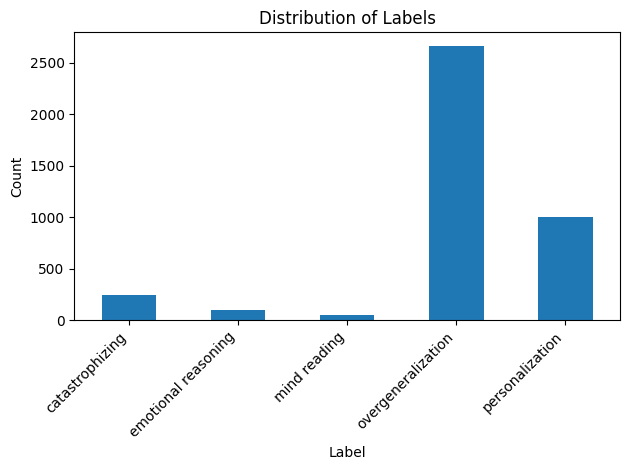

In [24]:
import matplotlib.pyplot as plt

label_counts = dataset.groupby('label').size()

plt.figure()
label_counts.plot(kind='bar')
plt.title('Distribution of Labels')
plt.xlabel('Label')
plt.ylabel('Count')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

# Baseline Model

In [25]:
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import SGDClassifier, LogisticRegression
from sklearn.metrics import classification_report
from sklearn import preprocessing
from sklearn.dummy import DummyClassifier
from sklearn import metrics

X = dataset['full_text']
y = dataset['label']

le = preprocessing.LabelEncoder()
y = le.fit_transform(y)

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Vectorize the text data
tfidf = TfidfVectorizer(max_features=5000)
X_train_tfidf = tfidf.fit_transform(X_train)
X_test_tfidf = tfidf.transform(X_test)

model = LogisticRegression(C=1.0)
model.fit(X_train_tfidf, y_train)

# Evaluate the model
y_pred = model.predict(X_test_tfidf)

print(classification_report(y_test, y_pred))

print(metrics.confusion_matrix(y_test, y_pred))
print(metrics.accuracy_score(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.00      0.00      0.00        37
           1       0.00      0.00      0.00        21
           2       0.00      0.00      0.00         7
           3       0.79      0.96      0.87       557
           4       0.63      0.45      0.53       187

    accuracy                           0.77       809
   macro avg       0.29      0.28      0.28       809
weighted avg       0.69      0.77      0.72       809

[[  0   0   0  20  17]
 [  1   0   0  14   6]
 [  0   0   0   3   4]
 [  0   0   0 535  22]
 [  0   0   0 102  85]]
0.7663782447466008


/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


#Data Augmentation

In [26]:
dataset.iloc[0].to_dict()["full_text"]

'today i saw the man that saved me when i was being raped when i was years old i was raped behind a church next to the middle school i attended i remember it like it was yesterday it was a sunny day in the spring right before school was out for the summer i had a couple friends i hung out with and they persuaded me to skip class with them as we were leaving the campus security yelled at us to stop and everyone started running in different directions i ended up behind the church alone as i was catching my breath a man came around the corner he was much much bigger than i was at years old i was immediately scared and knew something bad was going to happen he came up to me and said i was the snack he had been looking for i tired to run but he grabbed me and pinned me against the wall i had no chance of escaping him he was such a big guy ill spare you all the details the assault happened for around minutes i was exhausted from trying to fight off this man and trying to scream while he was 

In [27]:
import nlpaug.augmenter.word as naw
import nltk
nltk.download('averaged_perceptron_tagger_eng')

def augment_text(df, aug, times, augmented_data):
  for index, row in df.iterrows():
    text = row["full_text"]
    label = row["label"]
    for _ in range(times):
      augmented_text = aug.augment(text)
      augmented_data["id"].append("1")
      augmented_data["full_text"].append(augmented_text[0])
      augmented_data["label"].append(label)


augmented_data = {"id": [], "full_text": [], "label": []}

[nltk_data] Downloading package averaged_perceptron_tagger_eng to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger_eng.zip.


In [28]:
aug = naw.SynonymAug(aug_src='wordnet')

catastrophizing = dataset[dataset["label"] == "catastrophizing"]
augment_text(catastrophizing, aug, 3, augmented_data)

emotional_reasoning = dataset[dataset["label"] == "emotional reasoning"]
augment_text(emotional_reasoning, aug, 3, augmented_data)

mind_reading = dataset[dataset["label"] == "mind reading"]
augment_text(mind_reading, aug, 3, augmented_data)

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...


In [29]:
aug = naw.RandomWordAug(action="swap")

catastrophizing = dataset[dataset["label"] == "catastrophizing"]
augment_text(catastrophizing, aug, 3, augmented_data)

emotional_reasoning = dataset[dataset["label"] == "emotional reasoning"]
augment_text(emotional_reasoning, aug, 3, augmented_data)

mind_reading = dataset[dataset["label"] == "mind reading"]
augment_text(mind_reading, aug, 3, augmented_data)

In [30]:
aug = naw.RandomWordAug()

catastrophizing = dataset[dataset["label"] == "catastrophizing"]
augment_text(catastrophizing, aug, 3, augmented_data)

emotional_reasoning = dataset[dataset["label"] == "emotional reasoning"]
augment_text(emotional_reasoning, aug, 3, augmented_data)

mind_reading = dataset[dataset["label"] == "mind reading"]
augment_text(mind_reading, aug, 3, augmented_data)

In [31]:
len(augmented_data["full_text"])

3456

In [32]:
augmented_data_df = pd.DataFrame(augmented_data)
augmented_data_df

,id,full_text,label
0,1,i was raped by a coworker and it has now cost ...,catastrophizing
1,1,i was raped by a coworker and it has now cost ...,catastrophizing
2,1,i was raped by a coworker and it has now cost ...,catastrophizing
3,1,my dad committed suicide earlier this year jus...,catastrophizing
4,1,my dad committed suicide earlier this year jus...,catastrophizing
...,...,...,...
3451,1,some random guy saved my life today and he did...,mind reading
3452,1,some random guy saved my life today and he did...,mind reading
3453,1,update my m girlfriend f has been weird since ...,mind reading
3454,1,update my m girlfriend f has been weird since ...,mind reading


In [33]:
more_data = pd.concat([augmented_data_df, dataset], axis=0)
more_data

,id,full_text,label
0,1,i was raped by a coworker and it has now cost ...,catastrophizing
1,1,i was raped by a coworker and it has now cost ...,catastrophizing
2,1,i was raped by a coworker and it has now cost ...,catastrophizing
3,1,my dad committed suicide earlier this year jus...,catastrophizing
4,1,my dad committed suicide earlier this year jus...,catastrophizing
...,...,...,...
4038,1ejtnih,mym wifesf career choice has turned into a soc...,personalization
4039,1dpc7ac,husband left our son without formula husband m...,personalization
4040,1ht8ogl,update boyfriend slept with someone else while...,catastrophizing
4041,1kpiccf,my husband m goes cycling way too much leaving...,personalization


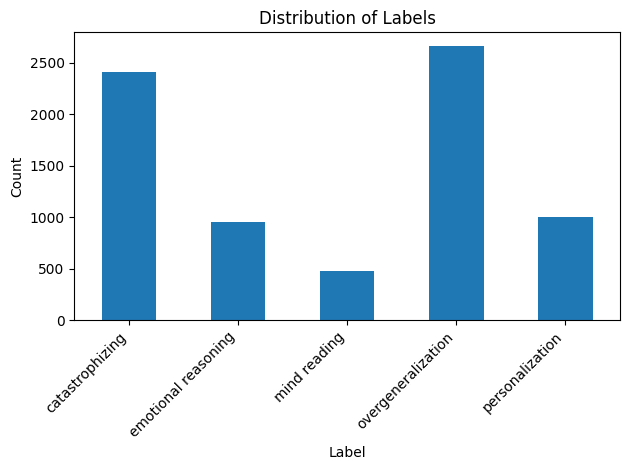

In [34]:
import matplotlib.pyplot as plt

label_counts = more_data.groupby('label').size()

plt.figure()
label_counts.plot(kind='bar')
plt.title('Distribution of Labels')
plt.xlabel('Label')
plt.ylabel('Count')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

# Model

In [40]:
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import SGDClassifier, LogisticRegression
from sklearn.metrics import classification_report
from sklearn import preprocessing
from sklearn.dummy import DummyClassifier
from sklearn import metrics
from sklearn import svm


X = more_data['full_text']
y = more_data['label']

le = preprocessing.LabelEncoder()
y = le.fit_transform(y)

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, shuffle=True)

# Vectorize the text data
tfidf = TfidfVectorizer(max_features=5000)
X_train_tfidf = tfidf.fit_transform(X_train)
X_test_tfidf = tfidf.transform(X_test)

model = svm.SVC(decision_function_shape='ovo')
# model = svm.LinearSVC()
model.fit(X_train_tfidf, y_train)

# Evaluate the model
y_pred = model.predict(X_test_tfidf)

print(classification_report(y_test, y_pred))

print(metrics.confusion_matrix(y_test, y_pred))
print(metrics.accuracy_score(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.99      1.00      1.00       518
           1       1.00      1.00      1.00       164
           2       1.00      1.00      1.00       102
           3       0.83      0.96      0.89       522
           4       0.83      0.44      0.57       194

    accuracy                           0.91      1500
   macro avg       0.93      0.88      0.89      1500
weighted avg       0.91      0.91      0.90      1500

[[518   0   0   0   0]
 [  0 164   0   0   0]
 [  0   0 102   0   0]
 [  2   0   0 502  18]
 [  3   0   0 106  85]]
0.914


In [ ]:
le.classes_

array(['catastrophizing', 'emotional reasoning', 'mind reading',
       'overgeneralization', 'personalization'], dtype=object)

In [ ]:
from joblib import dump, load

# Save both the model and vectorizer
dump(model, "models/logistic_model.pkl")
dump(tfidf, "models/tfidf_vectorizer.pkl")

['tfidf_vectorizer.pkl']